## Analyzing Many Models



In [2]:
import pandas as pd
import numpy as np
from google.cloud import bigquery

import matplotlib.pyplot as plt
import seaborn as sns


In [3]:

# First, let's load the necessary data
def load_data():
    """Load data from BigQuery"""
    client = bigquery.Client()
    
    # Load listings
    listings_query = """
    SELECT make, model, year, odometer
    FROM `umt-msba.carbitrage.processed_listing_pages`
    WHERE price < 75000
        AND price > 500
        AND odometer < 400000
        AND odometer > 1000
        AND year >= EXTRACT(YEAR FROM CURRENT_DATE()) - 50
        AND year <= EXTRACT(YEAR FROM CURRENT_DATE()) + 1
    """
    
    # Load model coefficients
    models_query = """
    SELECT *
    FROM `umt-msba.carbitrage.lm_lookup_table`
    """
    
    listings = client.query(listings_query).to_dataframe()
    models = client.query(models_query).to_dataframe()
    
    return listings, models


def generate_prediction_grid(listings, models):
    """Generate a grid of predictions for each make/model"""
    # Get distributions for each make/model
    distributions = listings.groupby(['make', 'model']).agg({
    'year': [lambda x: np.percentile(x, 25),
             lambda x: np.percentile(x, 50),
             lambda x: np.percentile(x, 75)],
    'odometer': [lambda x: np.percentile(x, 25),
                 lambda x: np.percentile(x, 50),
                 lambda x: np.percentile(x, 75)]
                 }).reset_index()

    # Rename columns for clarity
    distributions.columns = ['make', 'model', 
                            'year_p25', 'year_p50', 'year_p75',
                            'mile_p25', 'mile_p50', 'mile_p75'] 

    # Cast year columns to integers
    for col in ['year_p25', 'year_p50', 'year_p75']:
        distributions[col] = distributions[col].astype(int)

    # Drop duplicate rows based on 'make', 'model', and year columns
    distributions = distributions.drop_duplicates(subset=['make', 'model', 'year_p25', 'year_p50', 'year_p75'])


    # Create empty list to store all combinations
    rows = []
    
    # For each make/model
    for _, row in distributions.iterrows():
        # Get the model coefficients
        filtered_models = models[
            (models['make'] == row['make']) &
            (models['model'] == row['model'])
            ]
        
        if filtered_models.empty:
            # Skip this make/model if no coefficients are found
            continue
        
        model_coef = filtered_models.iloc[0]
        
        # Generate predictions for each combination
        for year, year_label in zip(
            [row['year_p25'], row['year_p50'], row['year_p75']],
            ['p25', 'p50', 'p75']
        ):
            year = int(year)  # Convert to integer
            for mileage, mile_label in zip(
                [row['mile_p25'], row['mile_p50'], row['mile_p75']],
                ['p25', 'p50', 'p75']
            ):
                predicted_price = (
                    model_coef['intercept'] +
                    model_coef['miles_coeff'] * np.log(mileage + 0.1) +
                    model_coef['condition_coeff'] * 1 +  # Setting condition to 1 (excellent)
                    model_coef['year_coeff'] * year +
                    (model_coef['year_miles_coeff'] * np.log(mileage + 0.1) * year)
                )
                
                rows.append({
                    'make': row['make'],
                    'model': row['model'],
                    'year': year,
                    'mileage': round(mileage, -2),  # Round to nearest thousand
                    'predicted_price': round(predicted_price, 2),
                    'age': pd.Timestamp.now().year - year,
                    'year_percentile': year_label,
                    'mileage_percentile': mile_label,
                    'r_squared': model_coef['r_squared'],
                    'sample_size': model_coef['sample_size']
                })
    
    # Convert to DataFrame
    prediction_df = pd.DataFrame(rows)
    
    # Filter out negative predictions
    prediction_df = prediction_df[prediction_df['predicted_price'] > 0]
    
    return prediction_df


In [4]:
# Load data
listings, models = load_data()


In [5]:
listings.head()

,make,model,year,odometer
0,suzuki,sidekick,1990,89700
1,lotus,elise,2005,94000
2,freightliner,None,2013,137000
3,saab,3,2005,106000
4,alfa romeo,spider,1987,40000


In [6]:

# Generate prediction grid
predictions = generate_prediction_grid(listings, models)


In [7]:
predictions.query("model == 'legend'")


,make,model,year,mileage,predicted_price,age,year_percentile,mileage_percentile,r_squared,sample_size
27,acura,legend,1990,107400.0,6609.83,34,p25,p25,0.328751,70
28,acura,legend,1990,148000.0,5317.52,34,p25,p50,0.328751,70
29,acura,legend,1990,180000.0,4527.88,34,p25,p75,0.328751,70
30,acura,legend,1991,107400.0,6899.07,33,p50,p25,0.328751,70
31,acura,legend,1991,148000.0,5670.27,33,p50,p50,0.328751,70
32,acura,legend,1991,180000.0,4919.44,33,p50,p75,0.328751,70
33,acura,legend,1993,107400.0,7477.55,31,p75,p25,0.328751,70
34,acura,legend,1993,148000.0,6375.78,31,p75,p50,0.328751,70
35,acura,legend,1993,180000.0,5702.57,31,p75,p75,0.328751,70


In [8]:

# Save to CSV
predictions.to_csv('car_value_predictions.csv', index=False)

# Print some summary statistics
print(f"Generated predictions for {predictions['make'].nunique()} makes and {len(set(zip(predictions['make'], predictions['model'])))} models")
print(f"Total prediction points: {len(predictions)}")



Generated predictions for 48 makes and 542 models
Total prediction points: 4878


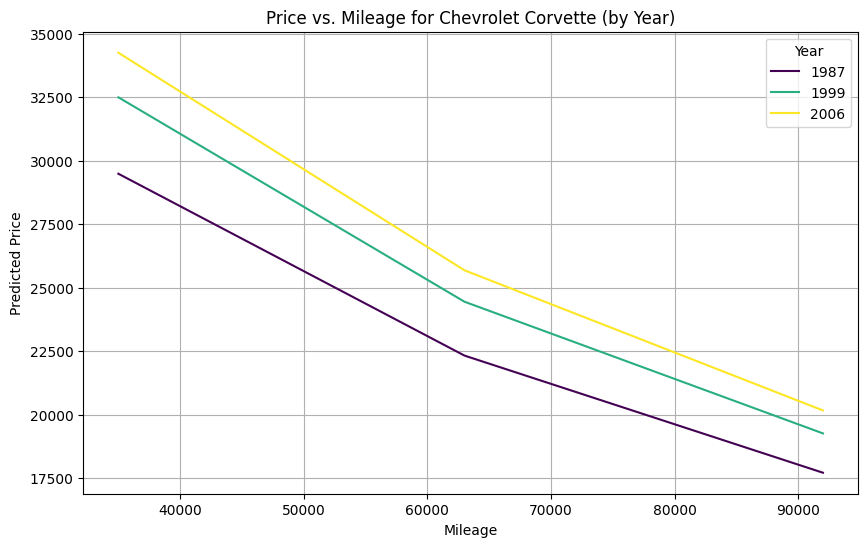

In [9]:
make = "chevrolet"
model = "corvette"
filtered_data = predictions[(predictions['make'] == make) & (predictions['model'] == model)]

# Create the plot
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=filtered_data, 
    x='mileage', 
    y='predicted_price', 
    hue='year', 
    palette='viridis'
)

# Add labels and title
plt.title(f"Price vs. Mileage for {make.capitalize()} {model.capitalize()} (by Year)")
plt.xlabel("Mileage")
plt.ylabel("Predicted Price")
plt.legend(title='Year')
plt.grid(True)

# Show the plot
plt.show()

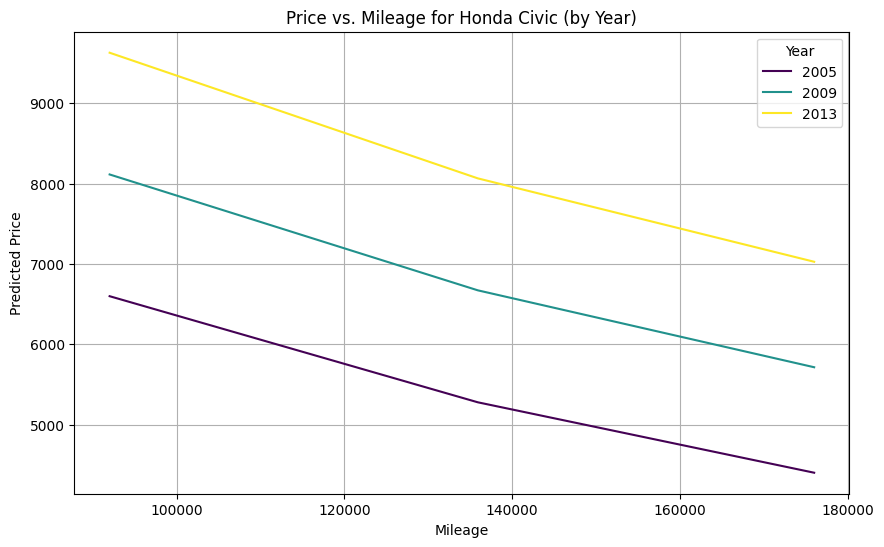

In [10]:
make = "honda"
model = "civic"
filtered_data = predictions[(predictions['make'] == make) & (predictions['model'] == model)]

# Create the plot
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=filtered_data, 
    x='mileage', 
    y='predicted_price', 
    hue='year', 
    palette='viridis'
)

# Add labels and title
plt.title(f"Price vs. Mileage for {make.capitalize()} {model.capitalize()} (by Year)")
plt.xlabel("Mileage")
plt.ylabel("Predicted Price")
plt.legend(title='Year')
plt.grid(True)

# Show the plot
plt.show()

In [11]:
predictions.query("make == 'tesla' & model == 'model 3'").sort_values('year')

,make,model,year,mileage,predicted_price,age,year_percentile,mileage_percentile,r_squared,sample_size
4770,tesla,model 3,2019,22900.0,27410.04,5,p25,p25,0.295739,1136
4771,tesla,model 3,2019,42000.0,25037.91,5,p25,p50,0.295739,1136
4772,tesla,model 3,2019,66600.0,23232.36,5,p25,p75,0.295739,1136
4773,tesla,model 3,2020,22900.0,27921.79,4,p50,p25,0.295739,1136
4774,tesla,model 3,2020,42000.0,26064.65,4,p50,p50,0.295739,1136
4775,tesla,model 3,2020,66600.0,24651.08,4,p50,p75,0.295739,1136
4776,tesla,model 3,2022,22900.0,28945.28,2,p75,p25,0.295739,1136
4777,tesla,model 3,2022,42000.0,28118.12,2,p75,p50,0.295739,1136
4778,tesla,model 3,2022,66600.0,27488.53,2,p75,p75,0.295739,1136


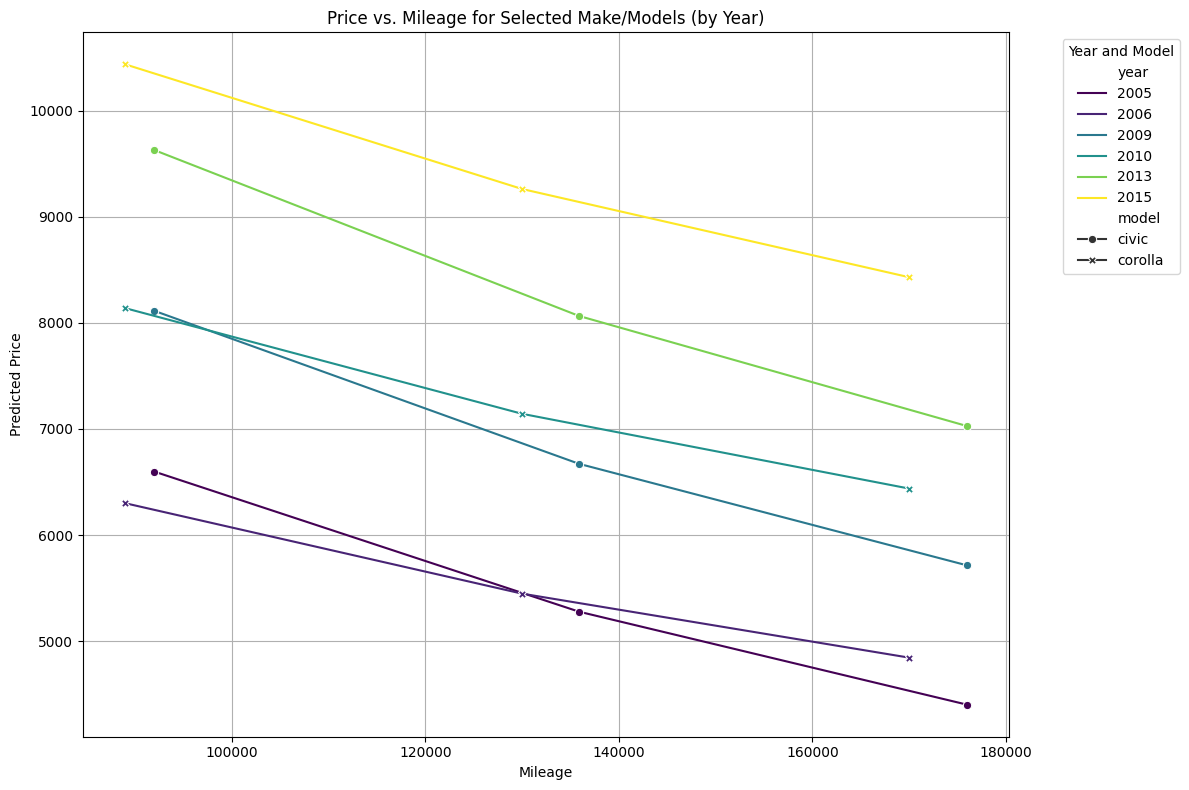

In [12]:
# Filter data for two make/models
make_model_combos = [
    ("toyota", "corolla"),
    ("honda", "civic")
]
filtered_data = predictions[
    predictions[['make', 'model']].apply(tuple, axis=1).isin(make_model_combos)
]

# Create the plot
plt.figure(figsize=(12, 8))
sns.lineplot(
    data=filtered_data, 
    x='mileage', 
    y='predicted_price', 
    hue='year', 
    style='model',  # Different styles for models
    palette='viridis',
    markers=True,
    dashes=False
)

# Add labels and title
plt.title("Price vs. Mileage for Selected Make/Models (by Year)")
plt.xlabel("Mileage")
plt.ylabel("Predicted Price")
plt.legend(title='Year and Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()


In [14]:
# Create the "make_model" column by combining "make" and "model"
predictions['make_model'] = predictions['make'] + '_' + predictions['model']


In [15]:
# Get unique values of 'make_model' and print them
unique_make_models = predictions['make_model'].unique()
print(unique_make_models)


['acura_cl' 'acura_ilx' 'acura_integra' 'acura_legend' 'acura_mdx'
 'acura_rdx' 'acura_rl' 'acura_rsx' 'acura_tl' 'acura_tlx' 'acura_tsx'
 'alfa romeo_spider' 'alfa romeo_stelvio' 'audi_3' 'audi_4' 'audi_6'
 'audi_a3' 'audi_a4' 'audi_a5' 'audi_a6' 'audi_a8' 'audi_allroad'
 'audi_q5' 'audi_q7' 'audi_quattro' 'audi_s4' 'audi_s5' 'audi_tt'
 'bentley_continental' 'bmw_1' 'bmw_2' 'bmw_3' 'bmw_3 series' 'bmw_4'
 'bmw_5 series' 'bmw_6' 'bmw_8' 'bmw_i3' 'bmw_m' 'bmw_m3' 'bmw_m5'
 'bmw_x3' 'bmw_x5' 'bmw_z3' 'buick_century' 'buick_enclave' 'buick_encore'
 'buick_envision' 'buick_lacrosse' 'buick_lesabre' 'buick_lucerne'
 'buick_park avenue' 'buick_rainier' 'buick_regal' 'buick_rendezvous'
 'buick_riviera' 'buick_roadmaster' 'buick_skylark' 'buick_verano'
 'cadillac_allante' 'cadillac_ats' 'cadillac_brougham' 'cadillac_cts'
 'cadillac_deville' 'cadillac_dts' 'cadillac_eldorado' 'cadillac_escalade'
 'cadillac_escalade esv' 'cadillac_escalade ext' 'cadillac_fleetwood'
 'cadillac_seville' 'cadillac_

In [16]:
# Define the list of desired make_model values
target_make_models = [
    "gmc_canyon", "toyota_tacoma", "ford_ranger",
    "chevrolet_colorado", "honda_ridgeline",
    "nissan_frontier"
]

# Filter rows from 'predictions' where 'make_model' matches the target values
pups = predictions[predictions['make_model'].isin(target_make_models)]

print(pups)


           make      model  year   mileage  predicted_price  age  \
891   chevrolet   colorado  2007   64400.0          9141.95   17   
892   chevrolet   colorado  2007  111000.0          7388.84   17   
893   chevrolet   colorado  2007  166000.0          6092.86   17   
894   chevrolet   colorado  2012   64400.0         14590.74   12   
895   chevrolet   colorado  2012  111000.0         12279.37   12   
896   chevrolet   colorado  2012  166000.0         10570.69   12   
897   chevrolet   colorado  2018   64400.0         21129.29    6   
898   chevrolet   colorado  2018  111000.0         18148.00    6   
899   chevrolet   colorado  2018  166000.0         15944.09    6   
1890       ford     ranger  1998  100000.0          7932.85   26   
1891       ford     ranger  1998  146000.0          5497.88   26   
1892       ford     ranger  1998  188000.0          3871.07   26   
1893       ford     ranger  2002  100000.0          8988.59   22   
1894       ford     ranger  2002  146000.0      

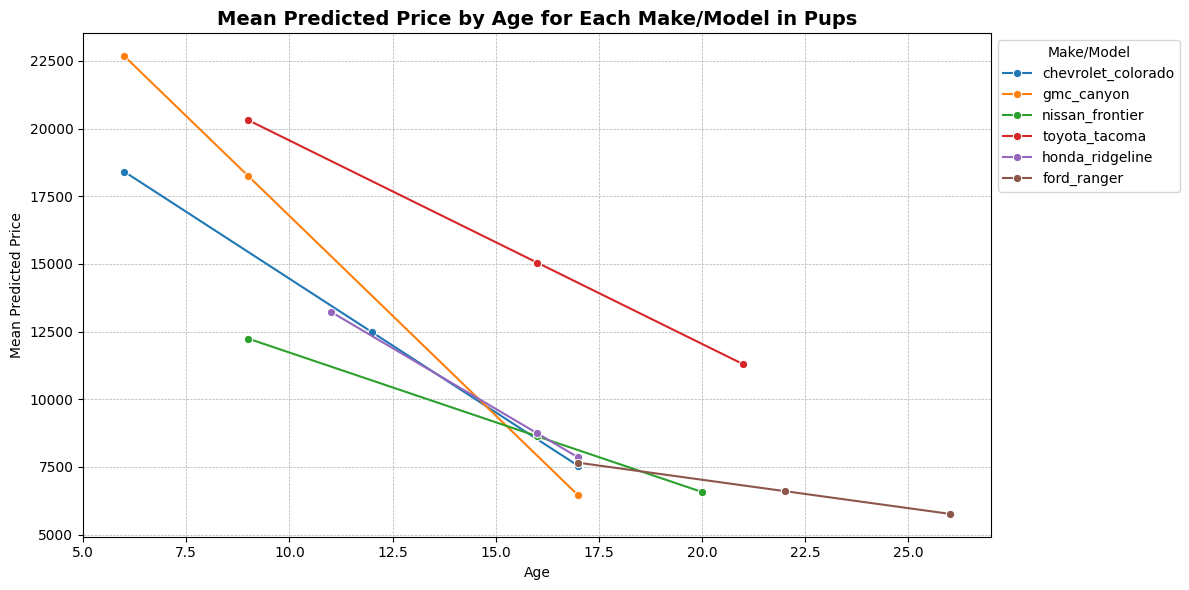

In [17]:
# Group data by 'year' and 'make_model' to calculate the mean of 'predicted_price'
pups_grouped = pups.groupby(['age', 'make_model'], as_index=False).agg({'predicted_price': 'mean'})

# Create the line plot
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=pups_grouped,
    x='age',
    y='predicted_price',
    hue='make_model',
    marker='o'
)

# Customize the plot
plt.title("Mean Predicted Price by Age for Each Make/Model in Pups", fontsize=14, fontweight='bold')
plt.xlabel("Age")
plt.ylabel("Mean Predicted Price")
plt.legend(title="Make/Model", loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

# Show the plot
plt.show()


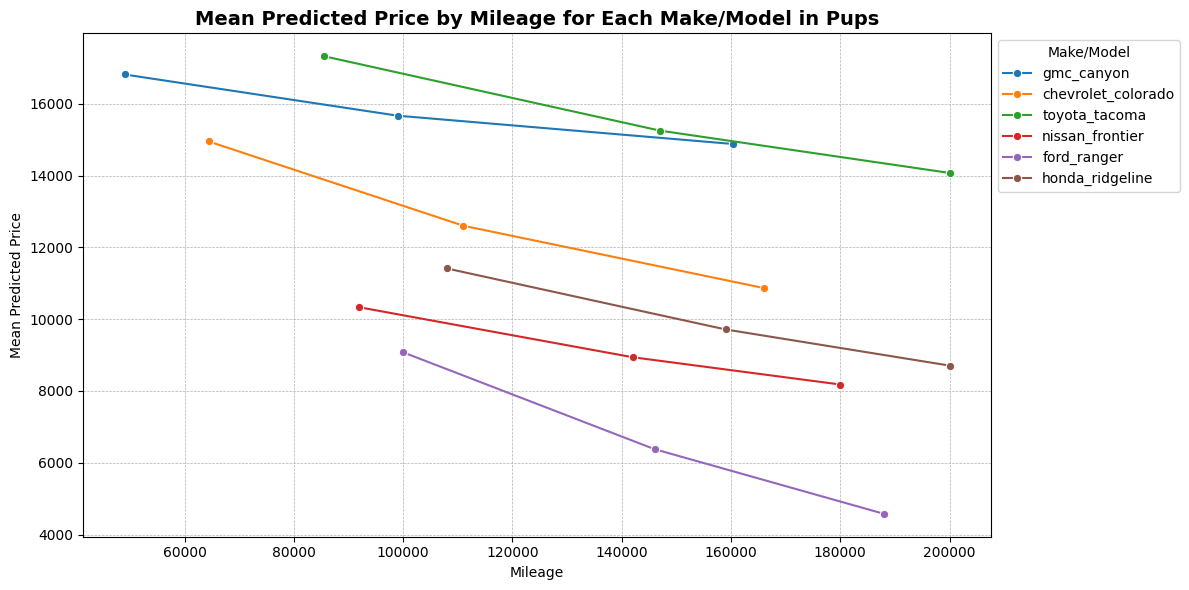

In [18]:
# Group data by 'mileage' and 'make_model' to calculate the mean of 'predicted_price'
pups_grouped_by_mileage = pups.groupby(['mileage', 'make_model'], as_index=False).agg({'predicted_price': 'mean'})

# Create the line plot
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=pups_grouped_by_mileage,
    x='mileage',
    y='predicted_price',
    hue='make_model',
    marker='o'
)

# Customize the plot
plt.title("Mean Predicted Price by Mileage for Each Make/Model in Pups", fontsize=14, fontweight='bold')
plt.xlabel("Mileage")
plt.ylabel("Mean Predicted Price")
plt.legend(title="Make/Model", loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

# Show the plot
plt.show()


In [19]:
print(pups.columns)

Index(['make', 'model', 'year', 'mileage', 'predicted_price', 'age',
       'year_percentile', 'mileage_percentile', 'r_squared', 'sample_size',
       'make_model'],
      dtype='object')


In [22]:
# Count the number of rows for each unique value of "make_model"
make_model_counts = pups['make_model'].value_counts()

# Print the counts
print(make_model_counts)


make_model
chevrolet_colorado    9
ford_ranger           9
gmc_canyon            9
honda_ridgeline       9
nissan_frontier       9
toyota_tacoma         9
Name: count, dtype: int64


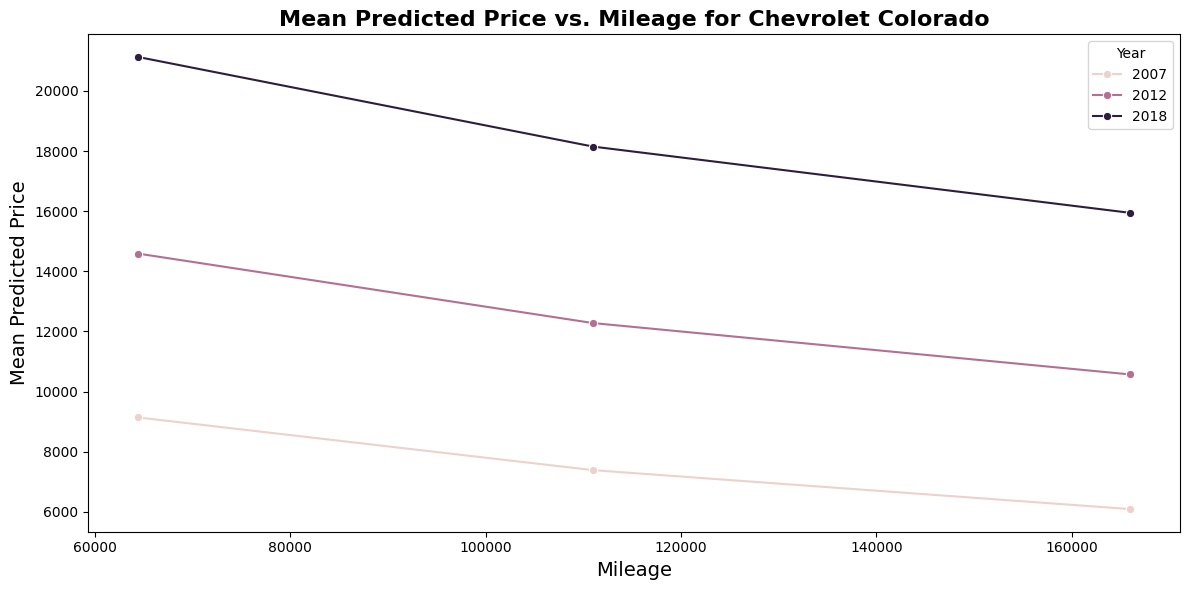

In [23]:

# Filter the data for "chevrolet_colorado"
filtered_data = pups[pups['make_model'] == 'chevrolet_colorado']

# Group by "mileage" and "year" and calculate the mean "predicted_price"
grouped_data = (
    filtered_data.groupby(['mileage', 'year'])['predicted_price']
    .mean()
    .reset_index()
)

# Plot the line graph
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=grouped_data,
    x='mileage',
    y='predicted_price',
    hue='year',
    marker="o",
)

# Customize the plot
plt.xlabel('Mileage', fontsize=14)
plt.ylabel('Mean Predicted Price', fontsize=14)
plt.title('Mean Predicted Price vs. Mileage for Chevrolet Colorado', fontsize=16, fontweight='bold')
plt.legend(title='Year', fontsize=10)
plt.grid(False)  # Remove gridlines as per your preferences
plt.tight_layout()

# Show the plot
plt.show()


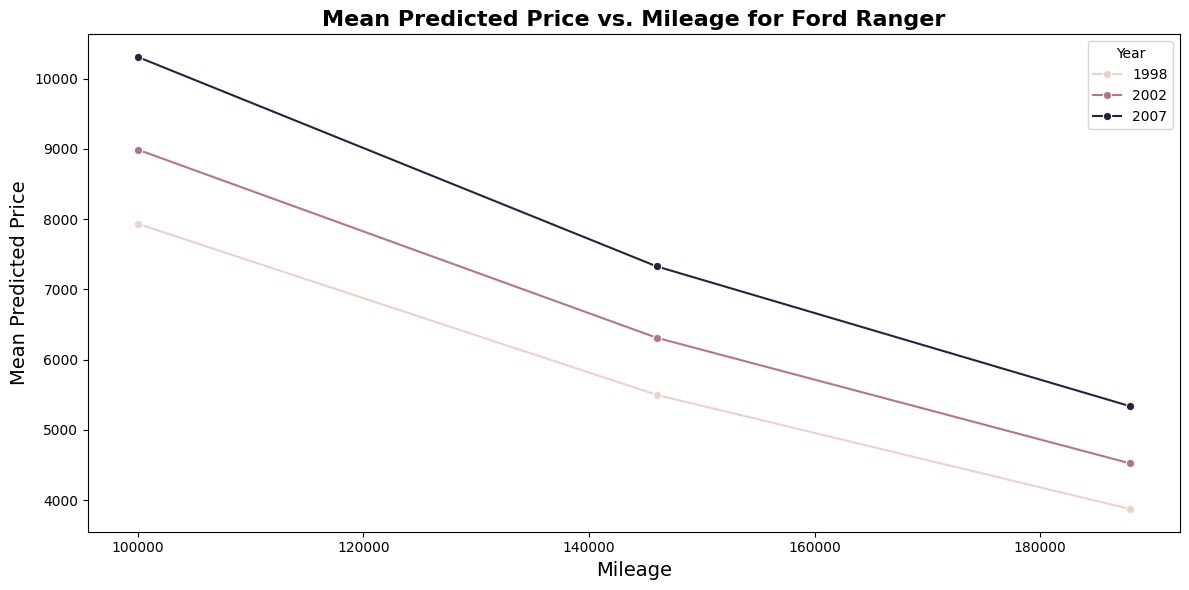

In [24]:

# Filter the data for "chevrolet_colorado"
filtered_data = pups[pups['make_model'] == 'ford_ranger']

# Group by "mileage" and "year" and calculate the mean "predicted_price"
grouped_data = (
    filtered_data.groupby(['mileage', 'year'])['predicted_price']
    .mean()
    .reset_index()
)

# Plot the line graph
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=grouped_data,
    x='mileage',
    y='predicted_price',
    hue='year',
    marker="o",
)

# Customize the plot
plt.xlabel('Mileage', fontsize=14)
plt.ylabel('Mean Predicted Price', fontsize=14)
plt.title('Mean Predicted Price vs. Mileage for Ford Ranger', fontsize=16, fontweight='bold')
plt.legend(title='Year', fontsize=10)
plt.grid(False)  # Remove gridlines as per your preferences
plt.tight_layout()

# Show the plot
plt.show()


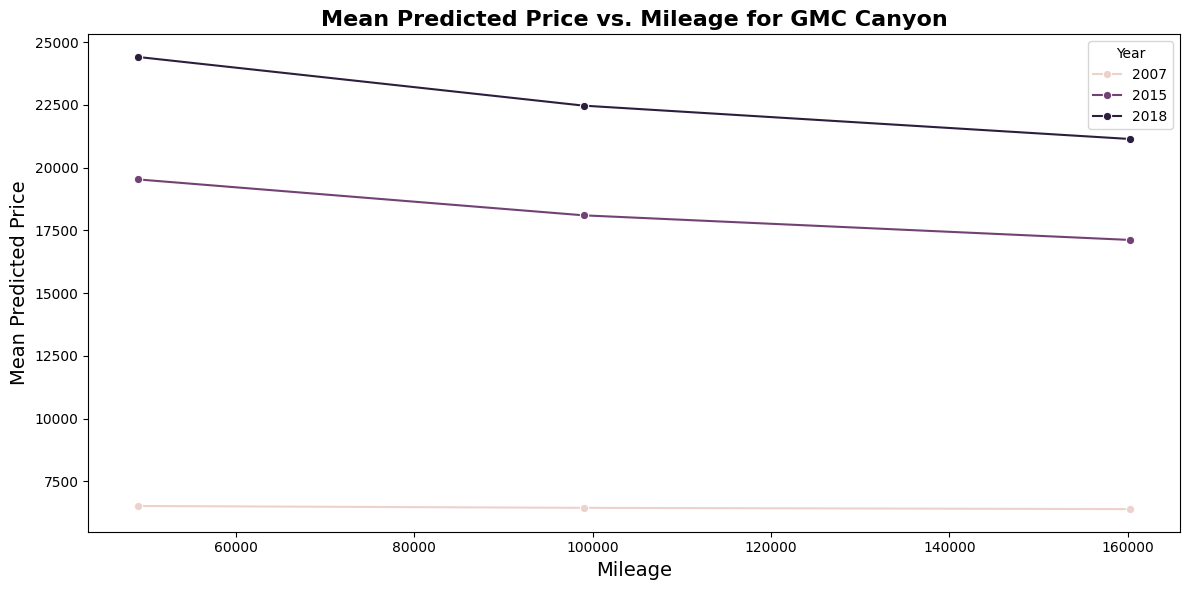

In [25]:

# Filter the data for "chevrolet_colorado"
filtered_data = pups[pups['make_model'] == 'gmc_canyon']

# Group by "mileage" and "year" and calculate the mean "predicted_price"
grouped_data = (
    filtered_data.groupby(['mileage', 'year'])['predicted_price']
    .mean()
    .reset_index()
)

# Plot the line graph
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=grouped_data,
    x='mileage',
    y='predicted_price',
    hue='year',
    marker="o",
)

# Customize the plot
plt.xlabel('Mileage', fontsize=14)
plt.ylabel('Mean Predicted Price', fontsize=14)
plt.title('Mean Predicted Price vs. Mileage for GMC Canyon', fontsize=16, fontweight='bold')
plt.legend(title='Year', fontsize=10)
plt.grid(False)  # Remove gridlines as per your preferences
plt.tight_layout()

# Show the plot
plt.show()


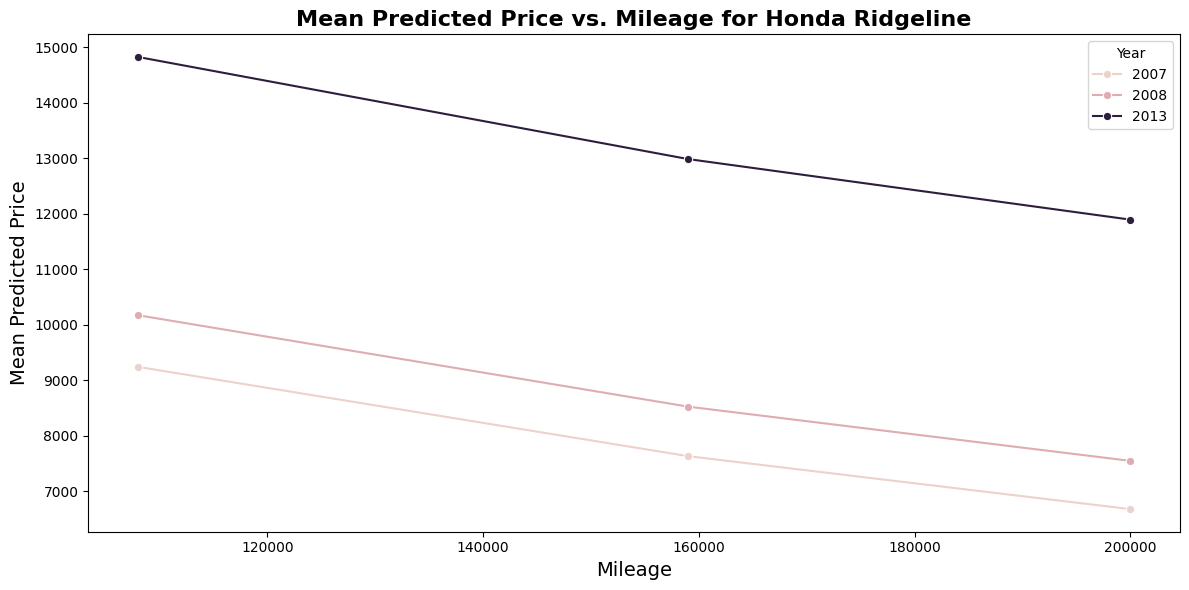

In [26]:

# Filter the data for "chevrolet_colorado"
filtered_data = pups[pups['make_model'] == 'honda_ridgeline']

# Group by "mileage" and "year" and calculate the mean "predicted_price"
grouped_data = (
    filtered_data.groupby(['mileage', 'year'])['predicted_price']
    .mean()
    .reset_index()
)

# Plot the line graph
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=grouped_data,
    x='mileage',
    y='predicted_price',
    hue='year',
    marker="o",
)

# Customize the plot
plt.xlabel('Mileage', fontsize=14)
plt.ylabel('Mean Predicted Price', fontsize=14)
plt.title('Mean Predicted Price vs. Mileage for Honda Ridgeline', fontsize=16, fontweight='bold')
plt.legend(title='Year', fontsize=10)
plt.grid(False)  # Remove gridlines as per your preferences
plt.tight_layout()

# Show the plot
plt.show()


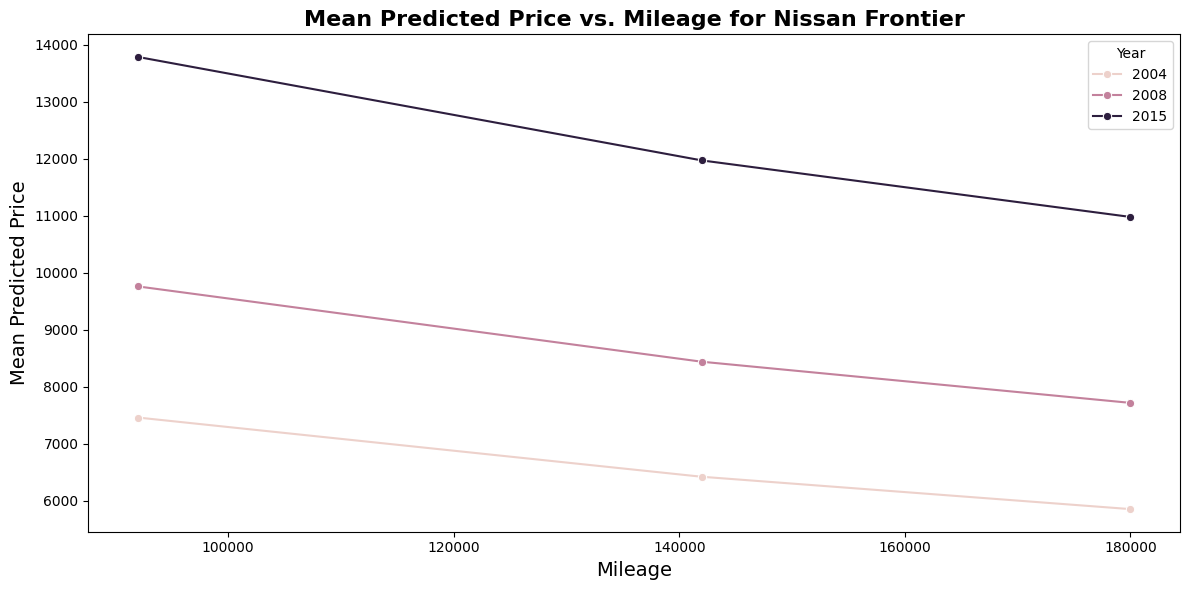

In [27]:

# Filter the data for "chevrolet_colorado"
filtered_data = pups[pups['make_model'] == 'nissan_frontier']

# Group by "mileage" and "year" and calculate the mean "predicted_price"
grouped_data = (
    filtered_data.groupby(['mileage', 'year'])['predicted_price']
    .mean()
    .reset_index()
)

# Plot the line graph
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=grouped_data,
    x='mileage',
    y='predicted_price',
    hue='year',
    marker="o",
)

# Customize the plot
plt.xlabel('Mileage', fontsize=14)
plt.ylabel('Mean Predicted Price', fontsize=14)
plt.title('Mean Predicted Price vs. Mileage for Nissan Frontier', fontsize=16, fontweight='bold')
plt.legend(title='Year', fontsize=10)
plt.grid(False)  # Remove gridlines as per your preferences
plt.tight_layout()

# Show the plot
plt.show()


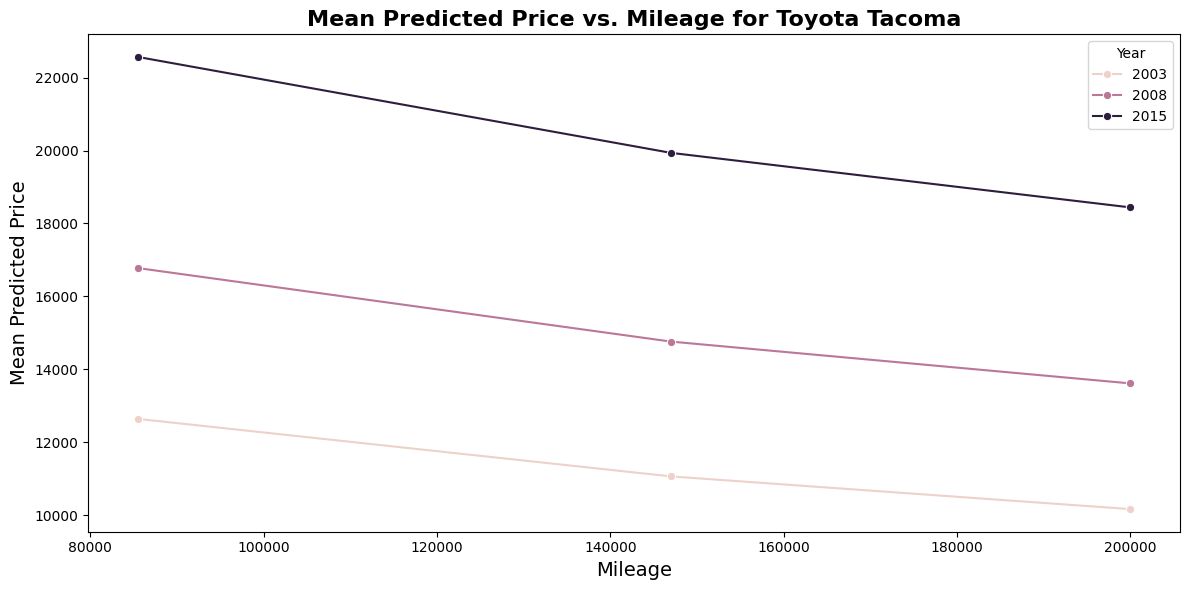

In [28]:

# Filter the data for "chevrolet_colorado"
filtered_data = pups[pups['make_model'] == 'toyota_tacoma']

# Group by "mileage" and "year" and calculate the mean "predicted_price"
grouped_data = (
    filtered_data.groupby(['mileage', 'year'])['predicted_price']
    .mean()
    .reset_index()
)

# Plot the line graph
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=grouped_data,
    x='mileage',
    y='predicted_price',
    hue='year',
    marker="o",
)

# Customize the plot
plt.xlabel('Mileage', fontsize=14)
plt.ylabel('Mean Predicted Price', fontsize=14)
plt.title('Mean Predicted Price vs. Mileage for Toyota Tacoma', fontsize=16, fontweight='bold')
plt.legend(title='Year', fontsize=10)
plt.grid(False)  # Remove gridlines as per your preferences
plt.tight_layout()

# Show the plot
plt.show()


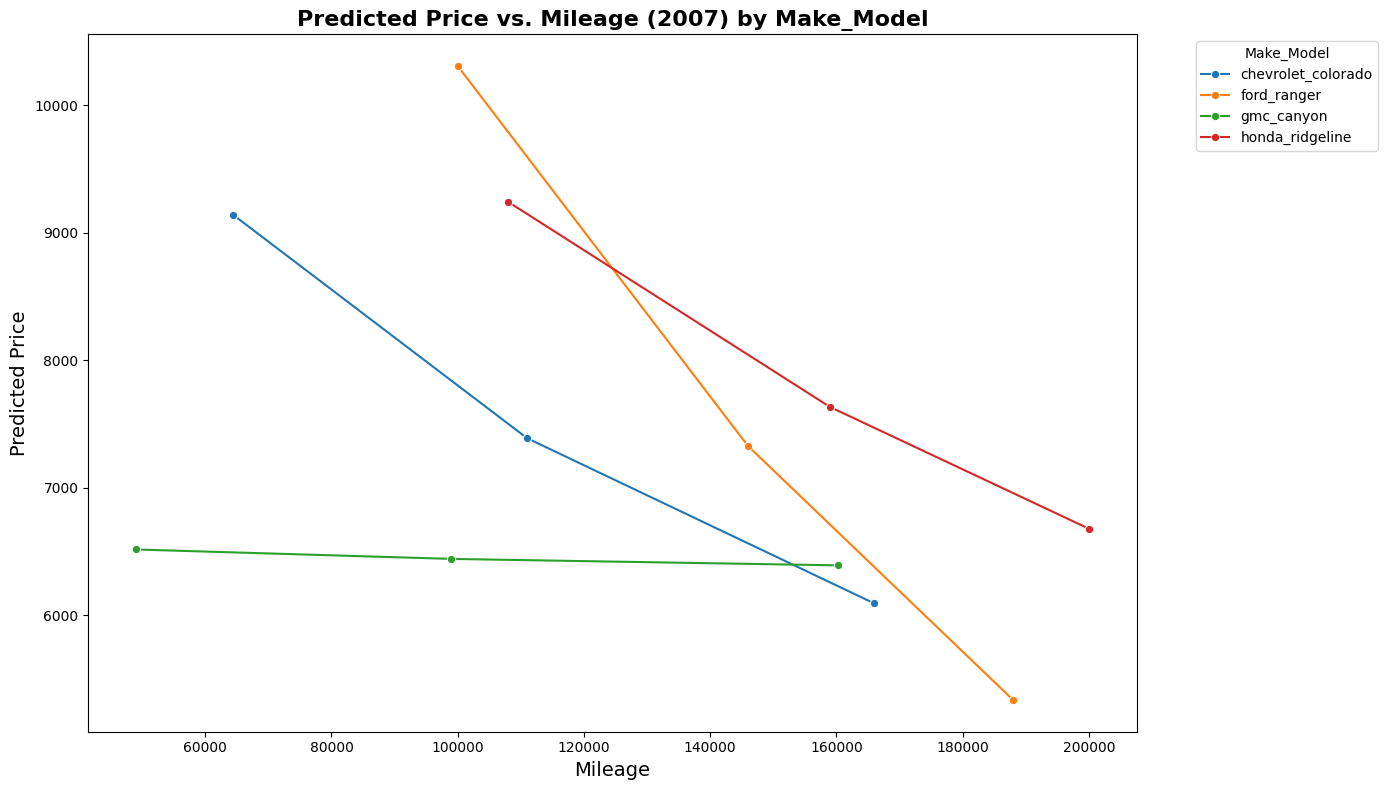

In [30]:
# Filter the data for "year" == 2007
filtered_data = pups[pups['year'] == 2007]

# Plot the line graph
plt.figure(figsize=(14, 8))
sns.lineplot(
    data=filtered_data,
    x='mileage',
    y='predicted_price',
    hue='make_model',
    marker="o"
)

# Customize the plot
plt.xlabel('Mileage', fontsize=14)
plt.ylabel('Predicted Price', fontsize=14)
plt.title('Predicted Price vs. Mileage (2007) by Make_Model', fontsize=16, fontweight='bold')
plt.legend(title='Make_Model', fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(False)  # Removes gridlines
plt.tight_layout()

# Show the plot
plt.show()


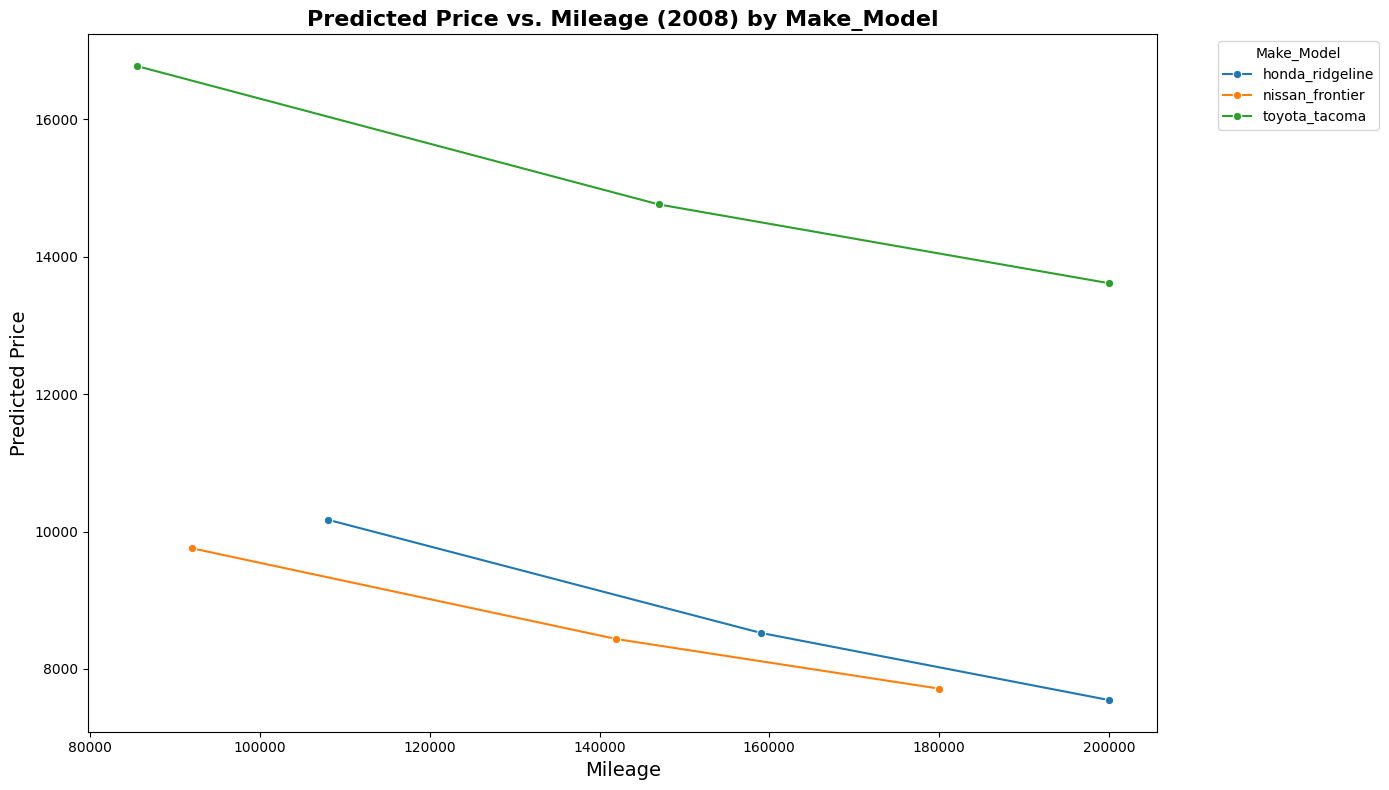

In [31]:
# Filter the data for "year" == 2008
filtered_data = pups[pups['year'] == 2008]

# Plot the line graph
plt.figure(figsize=(14, 8))
sns.lineplot(
    data=filtered_data,
    x='mileage',
    y='predicted_price',
    hue='make_model',
    marker="o"
)

# Customize the plot
plt.xlabel('Mileage', fontsize=14)
plt.ylabel('Predicted Price', fontsize=14)
plt.title('Predicted Price vs. Mileage (2008) by Make_Model', fontsize=16, fontweight='bold')
plt.legend(title='Make_Model', fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(False)  # Removes gridlines
plt.tight_layout()

# Show the plot
plt.show()


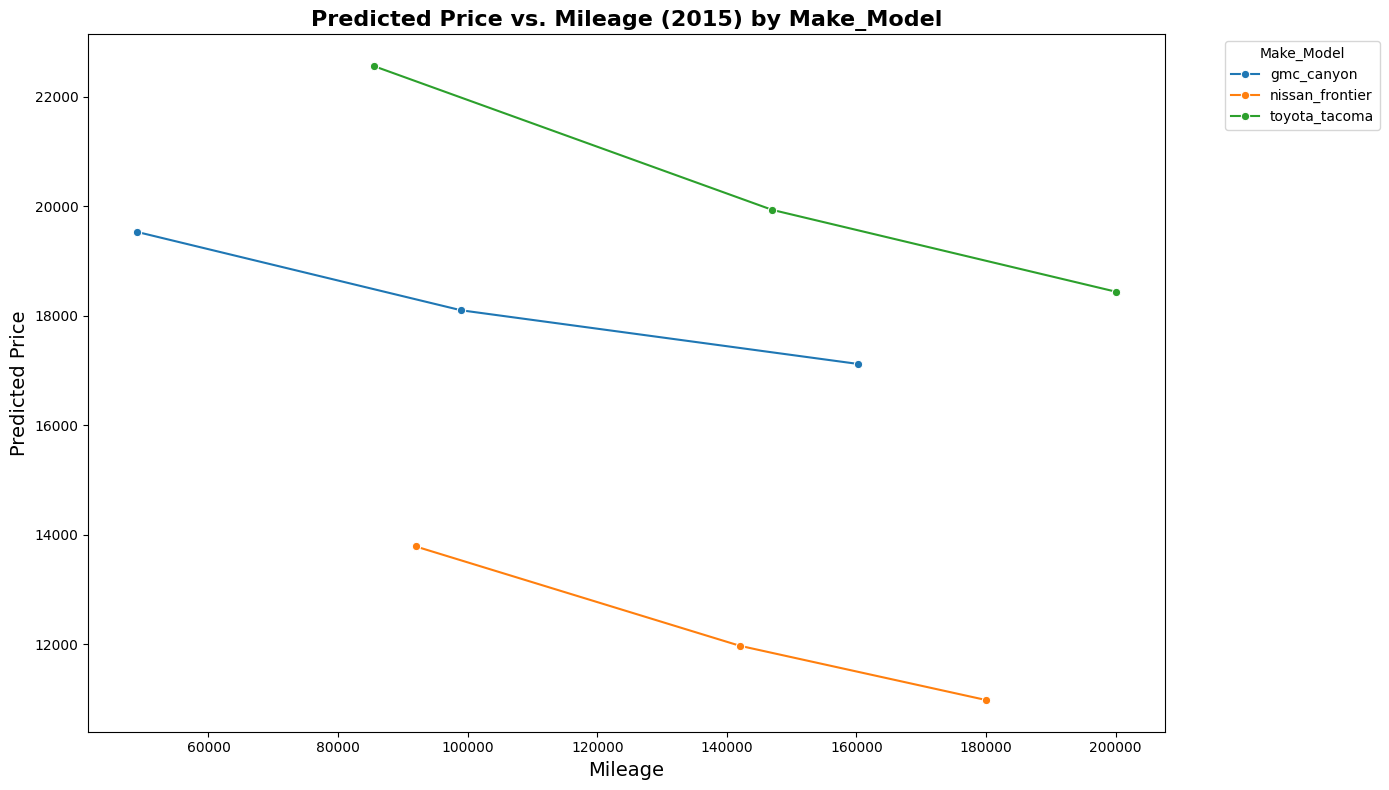

In [32]:
# Filter the data for "year" == 2015
filtered_data = pups[pups['year'] == 2015]

# Plot the line graph
plt.figure(figsize=(14, 8))
sns.lineplot(
    data=filtered_data,
    x='mileage',
    y='predicted_price',
    hue='make_model',
    marker="o"
)

# Customize the plot
plt.xlabel('Mileage', fontsize=14)
plt.ylabel('Predicted Price', fontsize=14)
plt.title('Predicted Price vs. Mileage (2015) by Make_Model', fontsize=16, fontweight='bold')
plt.legend(title='Make_Model', fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(False)  # Removes gridlines
plt.tight_layout()

# Show the plot
plt.show()
